In [1]:
import pandas as pd
import spacy
import numpy as np
import pyLDAvis.gensim_models
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from bs4 import BeautifulSoup



/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
df_articles = pd.read_csv('sävsjö_articles.csv')
df_articles.head()
df_articles = df_articles.dropna()
df_articles.head()

,ID,Title,Text
0,2,Aktiespararna säger ja till Gunvorbudet<span> ...,Aktiespararna rekommenderar sina medlemmar att...
2,7,Man fast i en timme i grop<span> - kuriren.nu<...,En man i 60-årsåldern föll ner i en grop som v...
3,8,Mannen fastnade i en grop  i flera timmar<spa...,En man i 60-årsåldern trillade ner i ett grävt...
4,56,En motorcykel,Här är den längre versionen.
5,66,Stulna braskaminer för 50 000 ska värma,Det börjar bli vinter och kallt. Då är det skö...


In [3]:
for col in df_articles.columns[1:]:
    df_articles[col] = df_articles[col].astype(str)
    df_articles[col] = df_articles[col].apply(lambda x: BeautifulSoup(x).get_text())
df_articles = df_articles.replace(r'[^\w\s]|_', '', regex=True)

/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [4]:
nlp = spacy.load("sv_core_news_lg")
stopwords = nlp.Defaults.stop_words

In [74]:
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
ent_remove = ['LOC','TME','MSR']
tokens = []
entities = []
i = 0 
for summary in nlp.pipe(df_articles['Text']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha and token.lemma_.lower() and token.ent_type_ not in ent_remove]
   ents = list(dict.fromkeys([ent.text.lower() for ent in summary.ents if ent.label_ not in ent_remove]))
   for ent in ents:
      if ent not in proj_tok:
         proj_tok.append(ent)
   tokens.append(proj_tok)
   entities.append(ents)
   

In [75]:
df_copy = df_articles.copy()
df_copy['tokens'] = tokens
df_copy['entities'] = entities
df_copy.iloc[5]['tokens']

['ny',
 'skolchef',
 'heta',
 'stefan',
 'claesson',
 'jobba',
 'börja',
 'basa',
 'läre',
 'elev',
 'vara',
 'klar',
 'vara',
 'förhandlingsfråga',
 'ny',
 'skolchef',
 'hittillsvarande',
 'arbetsgivare',
 'stefan claesson']

In [94]:
from gensim.models import TfidfModel
vocab = Dictionary(df_copy['tokens'])
len(vocab.token2id)
bagOfWords = [vocab.doc2bow(i) for i in df_copy['tokens']]

# Filter reduntant tokens based on tfidf score/ Then filter extreme values and keep top 2000 tokens for modelling
def tfidf_filtering(df,corpus,vocab):
    tfidf = TfidfModel(bagOfWords, id2word=vocab)
    tfidf[bagOfWords]
    ents2id = df['entities'].apply(lambda x: [vocab.token2id[tok] for tok in x]).tolist()   
    
    low_value = 0.2
    low_value_words = []
    
    for i in range(0,len(bagOfWords)):
        low_value_words += [id for id, value in tfidf[bagOfWords[i]] if value < low_value and id not in ents2id[i]] 
        
    vocab.filter_tokens(bad_ids=low_value_words)
    return vocab
    
filtered_vocab = tfidf_filtering(df_copy,bagOfWords,vocab)
filtered_vocab.filter_extremes(no_below=2, no_above=0.6, keep_n=2000)
len(filtered_vocab)


2000

In [95]:
corpus =  [filtered_vocab.doc2bow(i) for i in df_copy['tokens']]

In [96]:
filtered_vocab.token2id

{'hittillsvarande': 0,
 'stefan claesson': 1,
 'signalfel': 2,
 'spf orion': 3,
 'inbrottstjuev': 4,
 'towe widerberg': 5,
 'sm': 6,
 'seghalla': 7,
 'drogpåverka': 8,
 'sofia svensson': 9,
 'emanuel alvgard': 10,
 'guds': 11,
 'bilnyckl': 12,
 'tilltag': 13,
 'rv': 14,
 'omkörningsolycka': 15,
 'nådig': 16,
 'stefan gustafsson': 17,
 'stefan gustafsson kd': 18,
 'camilla andersson': 19,
 'hjertbergs': 20,
 'falli': 21,
 'andra världskriget': 22,
 'daniel böhlin': 23,
 'icabutiken': 24,
 'lasse stefanz': 25,
 'statistiska centralbyrån': 26,
 'hjärtlanda byalag': 27,
 'nyktra': 28,
 'jlt': 29,
 'fredrik zetterqvist': 30,
 'ingvar svensson': 31,
 'källarförråd': 32,
 'swedish cup': 33,
 'fortsättningsserie': 34,
 'nässjö hc': 35,
 'omplåstring': 36,
 'flickan': 37,
 'skepperstadsvägen': 38,
 'sävsjä': 39,
 'julottefärd': 40,
 'smhi\n': 41,
 'tunga': 42,
 'industrier ab': 43,
 'midway': 44,
 'midway holding': 45,
 'sävsjö trähus': 46,
 'hemvändarkväll': 47,
 'ladugårdsbyggnad': 48,
 'sälj

In [117]:
LDA_Model = LdaMulticore(corpus=corpus, id2word=filtered_vocab, iterations=50 , num_topics=4, workers = 4, passes=10)

In [118]:
LDA_Model.print_topics()


[(0,
  '0.022*"region jönköpings län" + 0.018*"ifk sävsjö" + 0.018*"lillian andersson" + 0.017*"helena gill" + 0.013*"sävsjö kommuns" + 0.011*"kristin nilsdotter isaksson" + 0.008*"vrigstad if" + 0.008*"kristin nilsdotter" + 0.008*"malin bengnér" + 0.007*"anders tegnell"'),
 (1,
  '0.052*"räddningstjänsten" + 0.013*"kristin nilsdotter isaksson" + 0.011*"annakarin yngvesson" + 0.011*"folkhälsomyndighetens" + 0.010*"sm" + 0.009*"harald petersson" + 0.009*"christer sjögren" + 0.009*"nils rydberg" + 0.008*"stefan gustafsson" + 0.008*"larsgöran andersson"'),
 (2,
  '0.019*"stefan claesson" + 0.014*"jan holmqvist" + 0.013*"lillian andersson" + 0.012*"hansåke andersson" + 0.012*"urban blücher" + 0.009*"arbetsförmedlingen" + 0.008*"ifk sävsjös" + 0.008*"esther" + 0.007*"linda elaine byman" + 0.007*"stenåke claesson"'),
 (3,
  '0.082*"stefan gustafsson" + 0.043*"stefan gustafsson kd" + 0.023*"lillian andersson" + 0.021*"stefan gustafsson kd kommunstyrelsens" + 0.018*"ola bengtsson" + 0.014*"sus

In [119]:
# Lemmatized articles as lists of tokens
lemmatized = df_copy['tokens'].tolist()

In [120]:
coherencemodel = CoherenceModel(model=LDA_Model, texts=lemmatized, dictionary=filtered_vocab, coherence='c_v')
baseline_coherence = coherencemodel.get_coherence()
print(f'Coherence value for baseline model: {baseline_coherence}')

Coherence value for baseline model: 0.41889632812711974


/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


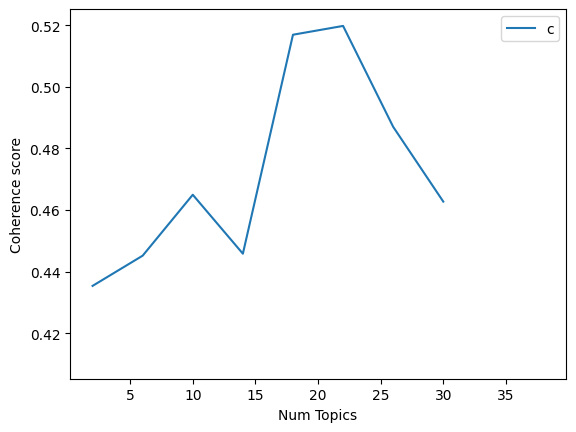

In [124]:
import matplotlib.pyplot as plt

# Compute coherence values for different numbers of topics 
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=filtered_vocab, iterations=50,chunksize= 200, num_topics= num_topics, workers = 4, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=filtered_vocab , corpus=corpus, texts=lemmatized, start=2, limit=40, step=4)

# Show graph
limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [125]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
optimal_score = coherence_values[best_result_index]
diff_from_base = optimal_score - baseline_coherence


In [158]:
print(f'''Optimal number of topics for the LDA model: {x[best_result_index]}\nCoherence Score: {optimal_score}''')
print(f'Coherent improvement: {diff_from_base}')
# Get top topic for a specific bag-of-words formatted text
def top_topic(bow):
    topic_dict = {}
    for topic in bow:
        topic_dict[topic[0]]= topic[1]
    top_topic = sorted(topic_dict.items(),key=lambda x: x[1],reverse=True)[0][0]
    return top_topic

df_copy['topic'] = [top_topic(optimal_model[corpus][i]) for i in range(len(df_copy['Text']))]
df_copy.head(15)

Optimal number of topics for the LDA model: 22
Coherence Score: 0.51982444996759
Coherent improvement: 0.10092812184047029


,ID,Title,Text,tokens,entities,topic
0,2,Aktiespararna säger ja till Gunvorbudet dise,Aktiespararna rekommenderar sina medlemmar att...,"[aktiespararna, rekommenderar, medlem, anta, b...",[gunvor group],0
2,7,Man fast i en timme i grop kurirennu,En man i 60årsåldern föll ner i en grop som va...,"[föll, grop, grävd, egen, tomt, timme, ligga, ...",[],0
3,8,Mannen fastnade i en grop i flera timmar exp...,En man i 60årsåldern trillade ner i ett grävt ...,"[trilla, gräva, hål, tomt, grop, stund, hitta,...",[david],0
4,56,En motorcykel,Här är den längre versionen,"[vara, version]",[],0
5,66,Stulna braskaminer för 50 000 ska värma,Det börjar bli vinter och kallt Då är det skön...,"[börja, vinter, vara, skönt, braskamin, visste...",[],0
6,67,Sävsjö får ny skolchef,Sävsjö kommun ska få en ny skolchef Han heter ...,"[ny, skolchef, heta, stefan, claesson, jobba, ...",[stefan claesson],8
7,70,Krösatågen kan bli försenade,Ett signalfel på sträckan SödertäljeStockholm ...,"[signalfel, sträcka, satte, stopp, tågtrafik, ...",[länstrafiken],21
8,72,Sävsjöpensionärer gör uppror,Stora grupper av pensionärer i Sävsjö är på kr...,"[grupp, pensionär, vara, krigsstig, landsting,...",[spf orion],16
9,78,Linus testar,Ett test jdklsa jfkldsa sjfkldsaö jfklsdaöjfls...,"[test, jfkldsa, sjfkldsaö]",[],0
10,79,Linus testar 2,Testar 2,[testa],[],0


In [145]:
display = pyLDAvis.gensim_models.prepare(optimal_model, corpus, optimal_model.id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(display)


/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importli

In [ ]:
optimal_model.print_topics()

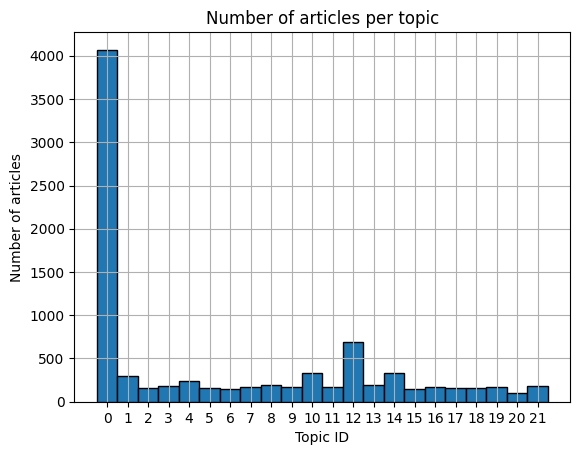

In [159]:
from matplotlib import pyplot as py


def plot_topic_hist(df, best_result_index):
    plt.xlabel('Topic ID')
    plt.ylabel('Number of articles')
    plt.title('Number of articles per topic')
    plt.gca().set_xticks(range(best_result_index))
    hist = df['topic'].hist(bins = np.arange(best_result_index+1)-0.5,edgecolor = "black")
    
plot_topic_hist(df_copy, x[best_result_index])


In [163]:
# Manually tuning initial LDA
display = pyLDAvis.gensim_models.prepare(LDA_Model, corpus, LDA_Model.id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(display)



/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [160]:
df_copy['topic'] = [top_topic(LDA_Model[corpus][i]) for i in range(len(df_copy['Text']))]
df_copy.head(15)

,ID,Title,Text,tokens,entities,topic
0,2,Aktiespararna säger ja till Gunvorbudet dise,Aktiespararna rekommenderar sina medlemmar att...,"[aktiespararna, rekommenderar, medlem, anta, b...",[gunvor group],0
2,7,Man fast i en timme i grop kurirennu,En man i 60årsåldern föll ner i en grop som va...,"[föll, grop, grävd, egen, tomt, timme, ligga, ...",[],0
3,8,Mannen fastnade i en grop i flera timmar exp...,En man i 60årsåldern trillade ner i ett grävt ...,"[trilla, gräva, hål, tomt, grop, stund, hitta,...",[david],0
4,56,En motorcykel,Här är den längre versionen,"[vara, version]",[],0
5,66,Stulna braskaminer för 50 000 ska värma,Det börjar bli vinter och kallt Då är det skön...,"[börja, vinter, vara, skönt, braskamin, visste...",[],0
6,67,Sävsjö får ny skolchef,Sävsjö kommun ska få en ny skolchef Han heter ...,"[ny, skolchef, heta, stefan, claesson, jobba, ...",[stefan claesson],2
7,70,Krösatågen kan bli försenade,Ett signalfel på sträckan SödertäljeStockholm ...,"[signalfel, sträcka, satte, stopp, tågtrafik, ...",[länstrafiken],1
8,72,Sävsjöpensionärer gör uppror,Stora grupper av pensionärer i Sävsjö är på kr...,"[grupp, pensionär, vara, krigsstig, landsting,...",[spf orion],3
9,78,Linus testar,Ett test jdklsa jfkldsa sjfkldsaö jfklsdaöjfls...,"[test, jfkldsa, sjfkldsaö]",[],0
10,79,Linus testar 2,Testar 2,[testa],[],0


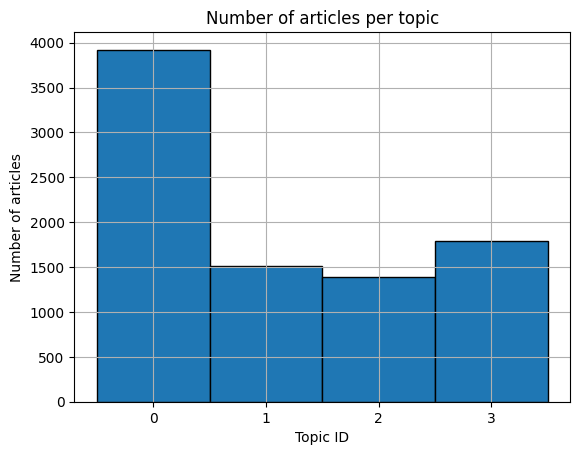

In [161]:
plot_topic_hist(df_copy,4)